In [1]:
import numpy as np
import pandas as pd 
import gurobipy as gp
from gurobipy import GRB
from bs4 import BeautifulSoup
import lxml

In [2]:
with open('NL4.xml', 'r') as f:
    data = f.read()

In [3]:
Bs_data = BeautifulSoup(data, "xml")

In [4]:
Bs_data

<?xml version="1.0" encoding="utf-8"?>
<Instance>
<MetaData>
<InstanceName>NL4</InstanceName>
<DataType>A</DataType>
<Contributor>Easton, Nemhauser, and Trick</Contributor>
<Date day="0" month="0" year="2001"/>
<Country/>
<Remarks>Based on National Hockey League</Remarks>
<Lowerbound infeasibility="0" objective="0"/>
</MetaData>
<Structure>
<Format leagueIds="0">
<numberRoundRobin>2</numberRoundRobin>
<compactness>C</compactness>
</Format>
<AdditionalGames/>
</Structure>
<ObjectiveFunction>
<Objective>TR</Objective>
</ObjectiveFunction>
<Data>
<Distances>
<distance dist="0" team1="0" team2="0"/>
<distance dist="745" team1="0" team2="1"/>
<distance dist="665" team1="0" team2="2"/>
<distance dist="929" team1="0" team2="3"/>
<distance dist="745" team1="1" team2="0"/>
<distance dist="0" team1="1" team2="1"/>
<distance dist="80" team1="1" team2="2"/>
<distance dist="337" team1="1" team2="3"/>
<distance dist="665" team1="2" team2="0"/>
<distance dist="80" team1="2" team2="1"/>
<distance dist

In [5]:
raw_distance_entries = Bs_data.find_all("distance")
distances = []
team1nrs = []
team2nrs = []
for e in raw_distance_entries:
    print(e)
    distances.append(e.get("dist"))
    team1nrs.append(e.get("team1"))
    team2nrs.append(e.get("team2"))

DF = pd.DataFrame(np.array([distances, team1nrs, team2nrs]).T, columns = ["distance", "team1", "team2"])

<distance dist="0" team1="0" team2="0"/>
<distance dist="745" team1="0" team2="1"/>
<distance dist="665" team1="0" team2="2"/>
<distance dist="929" team1="0" team2="3"/>
<distance dist="745" team1="1" team2="0"/>
<distance dist="0" team1="1" team2="1"/>
<distance dist="80" team1="1" team2="2"/>
<distance dist="337" team1="1" team2="3"/>
<distance dist="665" team1="2" team2="0"/>
<distance dist="80" team1="2" team2="1"/>
<distance dist="0" team1="2" team2="2"/>
<distance dist="380" team1="2" team2="3"/>
<distance dist="929" team1="3" team2="0"/>
<distance dist="337" team1="3" team2="1"/>
<distance dist="380" team1="3" team2="2"/>
<distance dist="0" team1="3" team2="3"/>


In [6]:
DF

,distance,team1,team2
0,0,0,0
1,745,0,1
2,665,0,2
3,929,0,3
4,745,1,0
5,0,1,1
6,80,1,2
7,337,1,3
8,665,2,0
9,80,2,1


In [7]:
raw_team_entries = Bs_data.find_all("team")
team_dict = {}
for e in raw_team_entries:
    team_dict[e.get("id")] = e.get("name")
team_dict

{'0': 'ATL', '1': 'NYM', '2': 'PHI', '3': 'MON'}

In [8]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph

In [9]:
arcs = list(DF[["team1", "team2"]].itertuples(index=False, name=None))

In [10]:
for i in range(DF.shape[0]):
    print(f"{DF["distance"][i]} - {DF["team1"][i]} - {DF["team2"][i]}")

0 - 0 - 0
745 - 0 - 1
665 - 0 - 2
929 - 0 - 3
745 - 1 - 0
0 - 1 - 1
80 - 1 - 2
337 - 1 - 3
665 - 2 - 0
80 - 2 - 1
0 - 2 - 2
380 - 2 - 3
929 - 3 - 0
337 - 3 - 1
380 - 3 - 2
0 - 3 - 3


{('0', '0', 0): Text(0.3102604913009266, 0.26042605533899343, '0'),
 ('0', '1', 0): Text(0.4869386039942598, -0.34948851480513277, '745'),
 ('0', '2', 0): Text(-0.02855713994055742, 0.5411503450478865, '665'),
 ('0', '3', 0): Text(-0.1481220891693844, -0.10936625612329476, '929'),
 ('1', '0', 0): Text(0.4869357293461942, -0.3494814893873829, '745'),
 ('1', '1', 0): Text(0.6636138420395274, -0.6031422305257801, '0'),
 ('1', '2', 0): Text(0.14811759801321378, 0.10936976306350643, '80'),
 ('1', '3', 0): Text(0.028552974231055184, -0.5411482116076671, '337'),
 ('2', '0', 0): Text(-0.02855599596081404, 0.5411487957882422, '665'),
 ('2', '1', 0): Text(0.14812261682401584, 0.10936109190784893, '80'),
 ('2', '2', 0): Text(-0.3673736272022979, 1.1781269145028637, '0'),
 ('2', '3', 0): Text(-0.48693472975465624, 0.34949826073793355, '380'),
 ('3', '0', 0): Text(-0.148118125667846, -0.1093645988480666, '929'),
 ('3', '1', 0): Text(0.028560161670315387, -0.5411509292284679, '337'),
 ('3', '2', 0):

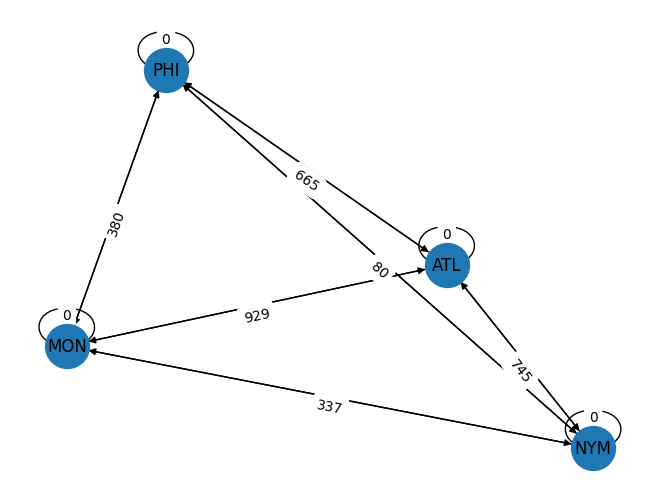

In [11]:
G = nx.MultiDiGraph()
for entry in team_dict:
    G.add_node(entry)

for i in range(DF.shape[0]):
    distance = int(DF["distance"][i])
    length = 0
    if int(distance) > 0:
        length = 1/int(distance)
    team1 = DF["team1"][i]
    team2 = DF["team2"][i]
    G.add_edge(team1, team2, weight=distance, length=length)

pos = nx.spring_layout(G)

nx.draw(G, pos=pos, with_labels=True, labels=team_dict, node_size = 1000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "weight"), verticalalignment="top")

### Attempted implementation of IP formulation by Ribeiro 2011

In [23]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict

In [24]:
model = gp.Model("Ribeiro2011")

In [125]:
x = defaultdict(lambda: defaultdict(dict))
y = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

nr_teams = len(team_dict)
nr_rounds = 2*(nr_teams - 1)


for i in (team_dict.values()):
    for j in (team_dict.values()):
        for k in range(nr_rounds):
            x[i, j, k] = model.addVar(name=f"x_{i}_{j}_{k}", vtype=GRB.BINARY)

for t in team_dict.values():
    for i in team_dict.values():
        for j in team_dict.values():
            for k in range(nr_rounds):
                y[t, i, j, k] = model.addVar(name=f"y_{t}_{i}_{j}_{k}", vtype=GRB.BINARY)

#TODO: Finalize implementation
#objective = gp.quicksum(gp.quicksum() for i in range(nr_teams))

In [126]:
DF["team1_name"] = [team_dict[x] for x in DF["team1"]]
DF["team2_name"] = [team_dict[x] for x in DF["team2"]]

In [127]:
d = defaultdict(lambda: defaultdict(dict))
for i in DF["team1_name"]:
    for j in DF["team2_name"]:
        d[i, j] = int(DF["distance"][(DF["team1_name"] == i) & (DF["team2_name"] == j)])

/tmp/ipykernel_14399/1985004505.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  d[i, j] = int(DF["distance"][(DF["team1_name"] == i) & (DF["team2_name"] == j)])


In [134]:
objective = gp.quicksum(gp.quicksum(d[i, j] * float(x[i, j, 1]) for j in range(nr_teams)) for i in range(nr_teams))

TypeError: float() argument must be a string or a real number, not 'collections.defaultdict'

#### Column generation testing

In [15]:
# TTP True Branch-and-Price Implementation

from itertools import product, combinations
import numpy as np
from copy import deepcopy
import time, math, heapq
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# ----------------------- USER INPUT -----------------------

team_names = []
dist_matrix = np.array([])

predefined_instance = "NL6"

if (predefined_instance == "NL4"):
    
    team_names = ["ATL","NYM","PHI","MON"]
    
    dist_matrix = np.array([
        [0, 665, 80, 380],
        [665, 0, 745, 929],
        [80, 745, 0, 337],
        [380, 929, 337, 0]
    ], dtype=float)

elif (predefined_instance == "NL6"):
    
    team_names = [
        "ATL",  # id=0
        "NYM",  # id=1
        "PHI",  # id=2
        "MON",  # id=3
        "FLA",  # id=4
        "PIT"   # id=5
    ]
    
    dist_matrix = np.array([
        #   ATL,   NYM,   PHI,   MON,   FLA,   PIT
        [    0,   745,   665,   929,   605,   521],  # ATL
        [  745,     0,    80,   337,  1090,   315],  # NYM
        [  665,    80,     0,   380,  1020,   257],  # PHI
        [  929,   337,   380,     0,  1380,   408],  # MON
        [  605,  1090,  1020,  1380,     0,  1010],  # FLA
        [  521,   315,   257,   408,  1010,     0]   # PIT
    ], dtype=float)
# ----------------------------------------------------------------

# Basic checks / preprocessing
if dist_matrix.shape[0] != dist_matrix.shape[1]:
    raise ValueError("Distance matrix must be square.")
if len(team_names) != dist_matrix.shape[0]:
    raise ValueError("Number of team names must equal matrix size.")

n = len(team_names)
m_slots = 2*(n-1)
pair_list = list(combinations(range(n), 2))
pair_to_idx = {pair:i for i,pair in enumerate(pair_list)}
P = len(pair_list)

print(f"Setup: n={n}, slots={m_slots}, pairs={P}")

# ----------------------- Pricing Subproblem Solver -----------------------

def solve_pricing_subproblem(team_idx, duals):
    """
    Solves the pricing subproblem for a single team using a shortest path algorithm
    on a state-space graph. This dynamically generates the tour with the
    minimum reduced cost. (Corrected Backtracking Logic)
    """
    opponents = [i for i in range(n) if i != team_idx]
    opp_map = {opp: i for i, opp in enumerate(opponents)}
    num_opp = len(opponents)

    # State: (slot, location, played_mask)
    # played_mask tuple: 0=not played, 1=played home, 2=played away, 3=played both
    source_node = (-1, team_idx, tuple([0] * num_opp))
    
    # DP table: labels[node] = (cost, predecessor_node, (opponent, is_home))
    # 'labels' will now accumulate all nodes, 'prev_labels' is for the current layer
    labels = {source_node: (0.0, None, None)}
    prev_labels = {source_node: (0.0, None, None)}

    for s in range(m_slots):
        next_labels = {}
        for node, (cost, _, _) in prev_labels.items():
            _, prev_loc, prev_mask = node
            
            for opp_team in opponents:
                opp_idx = opp_map[opp_team]
                
                possible_moves = []
                if prev_mask[opp_idx] == 0:
                    possible_moves.extend([(True, 1), (False, 2)])
                elif prev_mask[opp_idx] == 1:
                    possible_moves.append((False, 3))
                elif prev_mask[opp_idx] == 2:
                    possible_moves.append((True, 3))
                
                for is_home, new_mask_val in possible_moves:
                    venue = team_idx if is_home else opp_team
                    
                    new_mask = list(prev_mask)
                    new_mask[opp_idx] = new_mask_val
                    arc_cost = dist_matrix[prev_loc, venue]
                    
                    i, j = (team_idx, opp_team) if team_idx < opp_team else (opp_team, team_idx)
                    pair_idx = pair_to_idx[(i,j)]
                    relative_constr_idx = pair_idx * m_slots + s

                    if s == 0: arc_cost -= duals['team'][team_idx]
                    
                    sign = 1.0 if team_idx == i else -1.0
                    arc_cost -= sign * duals['pair_slot'][relative_constr_idx]

                    hf = 1.0 if is_home else 0.0
                    if team_idx == i:
                        arc_cost -= (hf - 1.0) * duals['home_cons'][relative_constr_idx]
                    else:
                        arc_cost -= hf * duals['home_cons'][relative_constr_idx]

                    new_node = (s, venue, tuple(new_mask))
                    new_cost = cost + arc_cost
                    if new_node not in next_labels or new_cost < next_labels[new_node][0]:
                        next_labels[new_node] = (new_cost, node, (opp_team, is_home))
        
        # --- BUG FIX IS HERE ---
        # Update the main labels dictionary and set the next layer to expand
        if not next_labels: # No path forward from this layer
            break
        labels.update(next_labels)
        prev_labels = next_labels

    # Find the best final node and add the cost of returning home
    best_final_node = None
    min_rc = 0.0
    final_mask = tuple([3] * num_opp)
    
    # Search for a valid final node in the last populated layer
    last_slot = max([node[0] for node in labels.keys()])
    if last_slot == m_slots - 1:
        for node, (cost, _, _) in labels.items():
            s_node, loc, mask = node
            if s_node == m_slots - 1 and mask == final_mask:
                final_cost = cost + dist_matrix[loc, team_idx]
                if final_cost < min_rc:
                    min_rc = final_cost
                    best_final_node = node
    
    if min_rc < -1e-6:
        tour = {'opp_seq': [0]*m_slots, 'home_flags': [False]*m_slots}
        curr = best_final_node
        while curr != source_node:
            s, _, _ = curr
            _, pred, (opp, is_home) = labels[curr] # This lookup will now succeed
            tour['opp_seq'][s] = opp
            tour['home_flags'][s] = is_home
            curr = pred

        def compute_true_cost(t_idx, opp_seq, home_flags):
            cost = 0.0
            prev = t_idx
            for s_idx, opp in enumerate(opp_seq):
                venue = t_idx if home_flags[s_idx] else opp
                cost += dist_matrix[prev, venue]
                prev = venue
            cost += dist_matrix[prev, t_idx]
            return cost
        
        tour['cost'] = compute_true_cost(team_idx, tour['opp_seq'], tour['home_flags'])
        tour['delta'] = np.zeros((n, m_slots), dtype=int)
        for s, opp in enumerate(tour['opp_seq']):
            tour['delta'][opp, s] = 1
        return tour
        
    return None
# ----------------------- Column Generation (Modified) -----------------------
def column_generation_gurobi(node_pool, forbid_triplets=None, forbid_signatures=None, require_list=None, cg_max_iters=500, tol=1e-9):
    pool = deepcopy(node_pool)
    it = 0
    while it < cg_max_iters:
        it += 1
        model, xvars, included_cols, constrs = build_master_model_gurobi(pool,
            forbid_triplets=forbid_triplets, forbid_signatures=forbid_signatures, require_list=require_list)
        model.optimize()

        if model.Status != GRB.OPTIMAL:
            print(f"Gurobi master problem not optimal (Status: {model.Status}). Node might be infeasible.")
            return None, None, None, None, None

        # Re-organize duals for easy access in pricing subproblem
        all_duals = np.array([c.Pi for c in constrs])
        duals = {
            'team': all_duals[0:n],
            'pair_slot': all_duals[n : n + P*m_slots],
            'home_cons': all_duals[n + P*m_slots : n + 2*P*m_slots],
            'require': all_duals[n + 2*P*m_slots:]
        }

        to_add = []
        for t in range(n):
            # *** THE KEY CHANGE IS HERE ***
            # Instead of iterating a list, we call the dynamic solver
            new_tour = solve_pricing_subproblem(t, duals)
            
            if new_tour:
                # Check if this tour signature is already in the pool
                sig = (t, tuple(new_tour['opp_seq']), tuple(new_tour['home_flags']))
                is_present = any(
                    (col['team'], tuple(col['tour']['opp_seq']), tuple(col['tour']['home_flags'])) == sig
                    for col in pool
                )
                if not is_present:
                    to_add.append({'team': t, 'tour': new_tour})

        if not to_add:
            x_vals = np.array([v.X for v in xvars])
            return model, xvars, included_cols, x_vals, model.ObjVal

        for col in to_add:
            pool.append(col)

    print("CG reached max iterations.")
    # Final solve
    model, xvars, included_cols, constrs = build_master_model_gurobi(pool,
        forbid_triplets=forbid_triplets, forbid_signatures=forbid_signatures, require_list=require_list)
    model.optimize()
    if model.Status != GRB.OPTIMAL: return None, None, None, None, None
    x_vals = np.array([v.X for v in xvars])
    return model, xvars, included_cols, x_vals, model.ObjVal

# ============================================================================================
#  The rest of the script (Master Problem Builder, Branching, etc.) remains the same.
#  I am including it here for a complete, runnable file.
# ============================================================================================

def compute_tour_cost(team_idx, opp_seq, home_flags, dist=dist_matrix):
    cost = 0.0
    prev = team_idx
    for s_idx, opp in enumerate(opp_seq):
        venue = team_idx if home_flags[s_idx] else opp
        cost += dist[prev, venue]
        prev = venue
    cost += dist[prev, team_idx]
    return float(cost)

def circle_method_pairings(n):
    assert n % 2 == 0
    teams_idx = list(range(n))
    fixed = teams_idx[-1]
    rot = teams_idx[:-1]
    rounds = []
    for r in range(n-1):
        pairs = []
        pairs.append(tuple(sorted((rot[0], fixed))))
        for k in range(1, n//2):
            i = rot[k]; j = rot[-k]
            pairs.append(tuple(sorted((i,j))))
        rounds.append(pairs)
        rot = [rot[-1]] + rot[:-1]
    return rounds + deepcopy(rounds)

def schedule_to_tours(pairings):
    schedule_opp = np.full((m_slots, n), -1, dtype=int)
    schedule_home = np.zeros((m_slots, n), dtype=bool)
    for s in range(m_slots):
        pairs = pairings[s]
        for (i,j) in pairs:
            if s < (n-1):
                schedule_opp[s,i] = j; schedule_home[s,i] = True
                schedule_opp[s,j] = i; schedule_home[s,j] = False
            else:
                schedule_opp[s,i] = j; schedule_home[s,i] = False
                schedule_opp[s,j] = i; schedule_home[s,j] = True
    tours = []
    for t in range(n):
        opp_seq = list(schedule_opp[:, t])
        home_flags = list(schedule_home[:, t])
        delta = np.zeros((n, m_slots), dtype=int)
        for s_idx, opp in enumerate(opp_seq): delta[opp, s_idx] = 1
        cost = compute_tour_cost(t, opp_seq, home_flags)
        tours.append({'opp_seq': opp_seq, 'home_flags': home_flags, 'delta': delta, 'cost': cost})
    return schedule_opp, schedule_home, tours

def build_master_model_gurobi(pool, forbid_triplets=None, forbid_signatures=None, require_list=None, gurobi_params=None):
    if forbid_triplets is None: forbid_triplets = set()
    if forbid_signatures is None: forbid_signatures = set()
    if require_list is None: require_list = []

    included_cols = []
    for col in pool:
        t = col['team']; tour = col['tour']
        sig = (t, tuple(tour['opp_seq']), tuple(tour['home_flags']))
        if sig in forbid_signatures: continue
        bad = False
        for s, opp in enumerate(tour['opp_seq']):
            if (t, opp, s) in forbid_triplets:
                bad = True; break
        if bad: continue
        included_cols.append(col)

    model = gp.Model("TTP_Master")
    model.Params.OutputFlag = 0
    if gurobi_params:
        for k,v in gurobi_params.items(): setattr(model.Params, k, v)

    xvars = model.addVars(len(included_cols), lb=0.0, obj=[float(c['tour']['cost']) for c in included_cols], name="x")
    model.update()

    constrs = []
    # 1) team coverage rows
    for t in range(n):
        expr = gp.LinExpr([(1.0, xvars[k]) for k, col in enumerate(included_cols) if col['team'] == t])
        constrs.append(model.addConstr(expr == 1.0, name=f"team_{t}"))

    # 2) pair-slot signed equality rows
    for pair_idx, (i,j) in enumerate(pair_list):
        for s in range(m_slots):
            expr = gp.LinExpr()
            for k, col in enumerate(included_cols):
                t = col['team']; tour = col['tour']
                if t == i and tour['delta'][j, s] == 1: expr += xvars[k]
                elif t == j and tour['delta'][i, s] == 1: expr += -xvars[k]
            constrs.append(model.addConstr(expr == 0.0, name=f"pair_{i}_{j}_slot_{s}"))

    # 3) home-consistency rows
    for pair_idx, (i,j) in enumerate(pair_list):
        for s in range(m_slots):
            expr = gp.LinExpr()
            for k, col in enumerate(included_cols):
                t = col['team']; tour = col['tour']
                if t == i and tour['opp_seq'][s] == j:
                    hf = 1.0 if tour['home_flags'][s] else 0.0
                    expr += (hf - 1.0) * xvars[k]
                elif t == j and tour['opp_seq'][s] == i:
                    hf = 1.0 if tour['home_flags'][s] else 0.0
                    expr += hf * xvars[k]
            constrs.append(model.addConstr(expr == 0.0, name=f"home_{i}_{j}_slot_{s}"))

    # 4) require rows
    for idx_req, (i,j,s) in enumerate(require_list):
        expr = gp.LinExpr([(1.0, xvars[k]) for k, col in enumerate(included_cols) if col['team'] == i and col['tour']['delta'][j, s] == 1])
        constrs.append(model.addConstr(expr == 1.0, name=f"require_{i}_{j}_{s}"))

    model.ModelSense = GRB.MINIMIZE
    model.update()
    return model, list(xvars.values()), included_cols, constrs

def compute_pairslot_z_from_solution(included_cols, x_vals):
    zvals = {}
    for pair_idx, (i,j) in enumerate(pair_list):
        for s in range(m_slots):
            z = sum(x_vals[k] for k, col in enumerate(included_cols) if col['team'] == i and col['tour']['delta'][j,s] == 1)
            zvals[(i,j,s)] = z
    return zvals

def is_solution_integral(x_vals, tol=1e-6):
    return all(abs(v - round(v)) < tol for v in x_vals)

def branch_and_price_gurobi(initial_pool, time_limit_nodes=36000.0, max_nodes=2000):
    start_time = time.time()
    node_id_gen = 0
    heap = []
    heapq.heappush(heap, (0.0, node_id_gen, initial_pool, frozenset(), frozenset(), tuple()))
    node_id_gen += 1
    best_int_obj = math.inf
    best_int_solution = None
    nodes_processed = 0

    while heap and (time.time() - start_time) < time_limit_nodes and nodes_processed < max_nodes:
        lb, node_id, node_pool, forbid_triplets, forbid_signatures, require_list = heapq.heappop(heap)
        if lb >= best_int_obj: continue
        nodes_processed += 1
        print(f"\nNode {node_id} (processed {nodes_processed}) lb={lb:.2f} |B_T|={len(forbid_triplets)} |B_S|={len(forbid_signatures)} |R|={len(require_list)}")
        
        current_pool = [col for col in node_pool]
        
        # --- BUG FIX IS HERE ---
        # Unpack the result first, then check for failure.
        res = column_generation_gurobi(current_pool, set(forbid_triplets), set(forbid_signatures), list(require_list))
        model, xvars, included_cols, x_vals, obj = res
        
        # Now, check if the run was successful. A None model indicates failure.
        if model is None:
            print(" -> Node LP infeasible, prune.")
            continue
        
        print(f" -> Node LP obj = {obj:.2f}, columns = {len(included_cols)}")
        if obj >= best_int_obj - 1e-9:
            print(" -> Bound >= incumbent, prune.")
            continue

        if is_solution_integral(x_vals):
            print(f" -> Integer solution found with obj = {obj:.2f}!")
            if obj < best_int_obj:
                best_int_obj = obj
                best_int_solution = [col for k, col in enumerate(included_cols) if x_vals[k] > 0.5]
                heap = [(p_lb, p_id, p_pool, p_ft, p_fs, p_req) for p_lb, p_id, p_pool, p_ft, p_fs, p_req in heap if p_lb < best_int_obj]
                heapq.heapify(heap)
            continue

        zvals = compute_pairslot_z_from_solution(included_cols, x_vals)
        frac_items = sorted([(abs(val - 0.5), (pair, val)) for pair, val in zvals.items() if 1e-6 < val < 1 - 1e-6])
        if frac_items:
            _, ((i,j,s), val) = frac_items[0]
            print(f" -> Branch on pair-slot z({i},{j},{s}) = {val:.4f}")
            child1_require = tuple(list(require_list) + [(i,j,s)])
            heapq.heappush(heap, (obj, node_id_gen, included_cols, forbid_triplets, forbid_signatures, child1_require)); node_id_gen += 1
            child2_trip = set(forbid_triplets); child2_trip.add((i,j,s)); child2_trip.add((j,i,s))
            heapq.heappush(heap, (obj, node_id_gen, included_cols, frozenset(child2_trip), forbid_signatures, require_list)); node_id_gen += 1
        else:
            frac_cols = [(k, x_vals[k]) for k, v in enumerate(x_vals) if 1e-6 < v < 1-1e-6]
            if not frac_cols:
                print(" -> Z and X are integral, but check failed. Pruning.")
                continue
            by_team = {}
            for k, val in frac_cols: by_team.setdefault(included_cols[k]['team'], []).append((val, k))
            target_team = max(by_team, key=lambda t: sum(v for v,k in by_team[t]))
            _, k_to_forbid = max(by_team[target_team])
            col_to_forbid = included_cols[k_to_forbid]
            sig_to_forbid = (col_to_forbid['team'], tuple(col_to_forbid['tour']['opp_seq']), tuple(col_to_forbid['tour']['home_flags']))
            print(f" -> Fallback branch on fractional tour for team {team_names[target_team]} (x_{k_to_forbid}={x_vals[k_to_forbid]:.4f})")
            child1_sigs = set(forbid_signatures); child1_sigs.add(sig_to_forbid)
            heapq.heappush(heap, (obj, node_id_gen, included_cols, forbid_triplets, frozenset(child1_sigs), require_list)); node_id_gen += 1
            other_frac_cols = [c for c in by_team[target_team] if c[1] != k_to_forbid]
            if other_frac_cols:
                _, k2_to_forbid = max(other_frac_cols)
                col2_to_forbid = included_cols[k2_to_forbid]
                sig2_to_forbid = (col2_to_forbid['team'], tuple(col2_to_forbid['tour']['opp_seq']), tuple(col2_to_forbid['tour']['home_flags']))
                child2_sigs = set(forbid_signatures); child2_sigs.add(sig2_to_forbid)
                heapq.heappush(heap, (obj, node_id_gen, included_cols, forbid_triplets, frozenset(child2_sigs), require_list)); node_id_gen += 1

    print(f"\nBranch-and-price finished. Nodes processed: {nodes_processed}")
    if best_int_solution is None:
        print("No integer solution found within limits.")
    else:
        print(f"Best integer obj = {best_int_obj:.2f}")
    return best_int_obj, best_int_solution

# ----------------------- Main Execution -----------------------
if __name__ == "__main__":
    # Prepare a basic initial pool of columns
    pairings = circle_method_pairings(n)
    _, _, initial_tours = schedule_to_tours(pairings)
    initial_pool = [{'team': t, 'tour': tour} for t, tour in enumerate(initial_tours)]
    print(f"Initial pool size: {len(initial_pool)}")
    
    start_total = time.time()
    best_obj, best_solution = branch_and_price_gurobi(initial_pool, time_limit_nodes=36000.0, max_nodes=2000)
    print(f"\nTotal elapsed time: {time.time() - start_total:.2f} seconds")

    if best_solution is not None:
        sel = []
        for col in sorted(best_solution, key=lambda c: c['team']):
            t = col['team']; tour = col['tour']
            sel.append({
                'team': team_names[t], 'cost': tour['cost'],
                'opp_seq': tuple(team_names[o] for o in tour['opp_seq']),
                'home_flags': tuple(['H' if h else 'A' for h in tour['home_flags']])
            })
        df = pd.DataFrame(sel)
        print("\nBest integer solution found:\n")
        print(df.to_string(index=False))
    else:
        print("\nNo integer solution was found.")

Setup: n=6, slots=10, pairs=15
Initial pool size: 6

Node 0 (processed 1) lb=0.00 |B_T|=0 |B_S|=0 |R|=0


KeyboardInterrupt: 

In [ ]:
# TTP True Branch-and-Price with Full Constraints (No-Repeater, Consecutive H/A)

from itertools import product, combinations
import numpy as np
from copy import deepcopy
import time, math, heapq
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# ----------------------- USER INPUT -----------------------
predefined_instance = "NL6"

if predefined_instance == "NL4":
    team_names = ["ATL", "NYM", "PHI", "MON"]
    dist_matrix = np.array([
        [0, 665, 80, 380],
        [665, 0, 745, 929],
        [80, 745, 0, 337],
        [380, 929, 337, 0]
    ], dtype=float)
elif predefined_instance == "NL6":
    team_names = ["ATL", "NYM", "PHI", "MON", "FLA", "PIT"]
    dist_matrix = np.array([
        [0, 745, 665, 929, 605, 521],
        [745, 0, 80, 337, 1090, 315],
        [665, 80, 0, 380, 1020, 257],
        [929, 337, 380, 0, 1380, 408],
        [605, 1090, 1020, 1380, 0, 1010],
        [521, 315, 257, 408, 1010, 0]
    ], dtype=float)
# ----------------------------------------------------------------

# Basic checks / preprocessing
n = len(team_names)
m_slots = 2 * (n - 1)
pair_list = list(combinations(range(n), 2))
pair_to_idx = {pair: i for i, pair in enumerate(pair_list)}
P = len(pair_list)
print(f"Setup: n={n}, slots={m_slots}, pairs={P}")
print(f"Solving for {predefined_instance} instance.")

# ----------------------- Pricing Subproblem Solver (Enhanced for Constraints) -----------------------
def solve_pricing_subproblem(team_idx, duals, initial_generation=False):
    """
    Solves the pricing subproblem with constraints. Has a special mode for
    generating the initial pool where negative reduced cost is not required.
    """
    opponents = [i for i in range(n) if i != team_idx]
    opp_map = {opp: i for i, opp in enumerate(opponents)}
    num_opp = len(opponents)

    source_node = (-1, team_idx, tuple([0] * num_opp), -1, 0)
    labels = {source_node: (0.0, None, None)}
    prev_labels = {source_node: (0.0, None, None)}

    for s in range(m_slots):
        next_labels = {}
        for node, (cost, _, _) in prev_labels.items():
            _, prev_loc, prev_mask, prev_opp, prev_streak = node
            for opp_team in opponents:
                if opp_team == prev_opp: continue

                opp_idx = opp_map[opp_team]
                possible_moves = []
                if prev_mask[opp_idx] == 0:
                    possible_moves.extend([(True, 1), (False, 2)])
                elif prev_mask[opp_idx] == 1:
                    possible_moves.append((False, 3))
                elif prev_mask[opp_idx] == 2:
                    possible_moves.append((True, 3))

                for is_home, new_mask_val in possible_moves:
                    if (is_home and prev_streak == 3) or (not is_home and prev_streak == -3):
                        continue
                    
                    new_streak = (prev_streak + 1) if prev_streak > 0 else 1 if is_home else (prev_streak - 1) if prev_streak < 0 else -1
                    venue = team_idx if is_home else opp_team
                    new_mask = list(prev_mask); new_mask[opp_idx] = new_mask_val
                    arc_cost = dist_matrix[prev_loc, venue]

                    i, j = (team_idx, opp_team) if team_idx < opp_team else (opp_team, team_idx)
                    pair_idx = pair_to_idx[(i, j)]
                    relative_constr_idx = pair_idx * m_slots + s

                    if s == 0: arc_cost -= duals['team'][team_idx]
                    sign = 1.0 if team_idx == i else -1.0
                    arc_cost -= sign * duals['pair_slot'][relative_constr_idx]
                    hf = 1.0 if is_home else 0.0
                    if team_idx == i:
                        arc_cost -= (hf - 1.0) * duals['home_cons'][relative_constr_idx]
                    else:
                        arc_cost -= hf * duals['home_cons'][relative_constr_idx]

                    new_node = (s, venue, tuple(new_mask), opp_team, new_streak)
                    new_cost = cost + arc_cost
                    if new_node not in next_labels or new_cost < next_labels[new_node][0]:
                        next_labels[new_node] = (new_cost, node, (opp_team, is_home))
        
        if not next_labels: break
        labels.update(next_labels)
        prev_labels = next_labels

    best_final_node = None
    min_rc = float('inf') # Initialize with infinity to find the minimum cost tour
    final_mask = tuple([3] * num_opp)
    
    last_slot = max([node[0] for node in labels.keys()] or [-1])
    if last_slot == m_slots - 1:
        for node, (cost, _, _) in labels.items():
            s_node, loc, mask, _, _ = node
            if s_node == m_slots - 1 and mask == final_mask:
                final_cost = cost + dist_matrix[loc, team_idx]
                if final_cost < min_rc:
                    min_rc = final_cost
                    best_final_node = node
    
    # <<< BUG FIX: Return the best tour if in initial_generation mode,
    # or if the reduced cost is negative. >>>
    if best_final_node is not None and (initial_generation or min_rc < -1e-6):
        tour = {'opp_seq': [0]*m_slots, 'home_flags': [False]*m_slots}
        curr = best_final_node
        while curr != source_node:
            s, _, _, _, _ = curr
            _, pred, (opp, is_home) = labels[curr]
            tour['opp_seq'][s] = opp
            tour['home_flags'][s] = is_home
            curr = pred
        
        def compute_true_cost(t_idx, opp_seq, home_flags):
            cost = 0.0; prev = t_idx
            for s_idx, opp in enumerate(opp_seq):
                venue = t_idx if home_flags[s_idx] else opp
                cost += dist_matrix[prev, venue]; prev = venue
            cost += dist_matrix[prev, t_idx]
            return cost
        
        tour['cost'] = compute_true_cost(team_idx, tour['opp_seq'], tour['home_flags'])
        tour['delta'] = np.zeros((n, m_slots), dtype=int)
        for s, opp in enumerate(tour['opp_seq']):
            tour['delta'][opp, s] = 1
        return tour
        
    return None
    
# ============================================================================================
#  The rest of the script remains unchanged as it correctly handles validly generated tours.
# ============================================================================================

def column_generation_gurobi(node_pool, forbid_triplets=None, forbid_signatures=None, require_list=None, cg_max_iters=500, tol=1e-9):
    pool = deepcopy(node_pool)
    it = 0
    while it < cg_max_iters:
        it += 1
        model, xvars, included_cols, constrs = build_master_model_gurobi(pool,
            forbid_triplets=forbid_triplets, forbid_signatures=forbid_signatures, require_list=require_list)
        model.optimize()

        if model.Status != GRB.OPTIMAL:
            # print(f"Gurobi master problem not optimal (Status: {model.Status}).")
            return None, None, None, None, None

        all_duals = np.array([c.Pi for c in constrs])
        duals = {
            'team': all_duals[0:n],
            'pair_slot': all_duals[n : n + P*m_slots],
            'home_cons': all_duals[n + P*m_slots : n + 2*P*m_slots],
            'require': all_duals[n + 2*P*m_slots:]
        }

        to_add = []
        for t in range(n):
            new_tour = solve_pricing_subproblem(t, duals)
            if new_tour:
                sig = (t, tuple(new_tour['opp_seq']), tuple(new_tour['home_flags']))
                is_present = any(
                    (col['team'], tuple(col['tour']['opp_seq']), tuple(col['tour']['home_flags'])) == sig
                    for col in pool
                )
                if not is_present:
                    to_add.append({'team': t, 'tour': new_tour})

        if not to_add:
            x_vals = np.array([v.X for v in xvars])
            return model, xvars, included_cols, x_vals, model.ObjVal

        for col in to_add:
            pool.append(col)

    print("CG reached max iterations.")
    model, xvars, included_cols, constrs = build_master_model_gurobi(pool,
        forbid_triplets=forbid_triplets, forbid_signatures=forbid_signatures, require_list=require_list)
    model.optimize()
    if model.Status != GRB.OPTIMAL: return None, None, None, None, None
    x_vals = np.array([v.X for v in xvars])
    return model, xvars, included_cols, x_vals, model.ObjVal

def compute_tour_cost(team_idx, opp_seq, home_flags, dist=dist_matrix):
    cost = 0.0; prev = team_idx
    for s_idx, opp in enumerate(opp_seq):
        venue = team_idx if home_flags[s_idx] else opp
        cost += dist[prev, venue]
        prev = venue
    cost += dist[prev, team_idx]
    return float(cost)

def circle_method_pairings(n):
    assert n % 2 == 0
    teams_idx = list(range(n)); fixed = teams_idx[-1]; rot = teams_idx[:-1]
    rounds = []
    for r in range(n-1):
        pairs = [tuple(sorted((rot[0], fixed)))]
        for k in range(1, n//2):
            i = rot[k]; j = rot[-k]
            pairs.append(tuple(sorted((i,j))))
        rounds.append(pairs)
        rot = [rot[-1]] + rot[:-1]
    return rounds + deepcopy(rounds)

def schedule_to_tours(pairings):
    schedule_opp = np.full((m_slots, n), -1, dtype=int)
    schedule_home = np.zeros((m_slots, n), dtype=bool)
    for s in range(m_slots):
        for (i,j) in pairings[s]:
            if s < (n-1):
                schedule_opp[s,i] = j; schedule_home[s,i] = True
                schedule_opp[s,j] = i; schedule_home[s,j] = False
            else:
                schedule_opp[s,i] = j; schedule_home[s,i] = False
                schedule_opp[s,j] = i; schedule_home[s,j] = True
    tours = []
    for t in range(n):
        opp_seq = list(schedule_opp[:, t])
        home_flags = list(schedule_home[:, t])
        delta = np.zeros((n, m_slots), dtype=int)
        for s_idx, opp in enumerate(opp_seq): delta[opp, s_idx] = 1
        cost = compute_tour_cost(t, opp_seq, home_flags)
        tours.append({'opp_seq': opp_seq, 'home_flags': home_flags, 'delta': delta, 'cost': cost})
    return schedule_opp, schedule_home, tours

def build_master_model_gurobi(pool, forbid_triplets=None, forbid_signatures=None, require_list=None):
    if forbid_triplets is None: forbid_triplets = set()
    if forbid_signatures is None: forbid_signatures = set()
    if require_list is None: require_list = []
    included_cols = []
    for col in pool:
        t, tour = col['team'], col['tour']
        sig = (t, tuple(tour['opp_seq']), tuple(tour['home_flags']))
        if sig in forbid_signatures: continue
        if any((t, opp, s) in forbid_triplets for s, opp in enumerate(tour['opp_seq'])): continue
        included_cols.append(col)

    model = gp.Model("TTP_Master")
    model.Params.OutputFlag = 0
    
    # <<< ENHANCEMENT: Define a large penalty for artificial variables >>>
    M_PENALTY = 1e6

    xvars = model.addVars(len(included_cols), lb=0.0, obj=[float(c['tour']['cost']) for c in included_cols], name="x")
    model.update()
    constrs = []
    
    # 1) team coverage rows (These are "hard" constraints, no artificial variables)
    for t in range(n):
        expr = gp.LinExpr([(1.0, xvars[k]) for k, col in enumerate(included_cols) if col['team'] == t])
        constrs.append(model.addConstr(expr == 1.0, name=f"team_{t}"))

    # 2) pair-slot signed equality rows
    for pair_idx, (i,j) in enumerate(pair_list):
        for s in range(m_slots):
            expr = gp.LinExpr()
            for k, col in enumerate(included_cols):
                t, tour = col['team'], col['tour']
                if t == i and tour['delta'][j, s] == 1: expr += xvars[k]
                elif t == j and tour['delta'][i, s] == 1: expr += -xvars[k]
            
            # <<< ARTIFICIAL VARIABLES to ensure feasibility >>>
            s_plus = model.addVar(lb=0.0, obj=M_PENALTY, name=f"s_plus_pair_{i}_{j}_{s}")
            s_minus = model.addVar(lb=0.0, obj=M_PENALTY, name=f"s_minus_pair_{i}_{j}_{s}")
            constrs.append(model.addConstr(expr - s_plus + s_minus == 0.0, name=f"pair_{i}_{j}_slot_{s}"))

    # 3) home-consistency rows
    for pair_idx, (i,j) in enumerate(pair_list):
        for s in range(m_slots):
            expr = gp.LinExpr()
            for k, col in enumerate(included_cols):
                t, tour = col['team'], col['tour']
                if t == i and tour['opp_seq'][s] == j:
                    expr += (1.0 if tour['home_flags'][s] else 0.0 - 1.0) * xvars[k]
                elif t == j and tour['opp_seq'][s] == i:
                    expr += (1.0 if tour['home_flags'][s] else 0.0) * xvars[k]

            # <<< ARTIFICIAL VARIABLES to ensure feasibility >>>
            s_plus_h = model.addVar(lb=0.0, obj=M_PENALTY, name=f"s_plus_home_{i}_{j}_{s}")
            s_minus_h = model.addVar(lb=0.0, obj=M_PENALTY, name=f"s_minus_home_{i}_{j}_{s}")
            constrs.append(model.addConstr(expr - s_plus_h + s_minus_h == 0.0, name=f"home_{i}_{j}_slot_{s}"))

    # 4) require rows (Hard constraints)
    for i,j,s in require_list:
        expr = gp.LinExpr([(1.0, xvars[k]) for k, col in enumerate(included_cols) if col['team'] == i and col['tour']['delta'][j, s] == 1])
        constrs.append(model.addConstr(expr == 1.0, name=f"require_{i}_{j}_{s}"))
        
    model.ModelSense = GRB.MINIMIZE
    model.update()
    return model, list(xvars.values()), included_cols, constrs

def compute_pairslot_z_from_solution(included_cols, x_vals):
    zvals = {}
    for pair_idx, (i,j) in enumerate(pair_list):
        for s in range(m_slots):
            z = sum(x_vals[k] for k, col in enumerate(included_cols) if col['team'] == i and col['tour']['delta'][j,s] == 1)
            zvals[(i,j,s)] = z
    return zvals

def is_solution_integral(x_vals, tol=1e-6):
    return all(abs(v - round(v)) < tol for v in x_vals)

def branch_and_price_gurobi(initial_pool, time_limit_nodes=36000.0, max_nodes=2000):
    start_time = time.time()
    node_id_gen = 0
    heap = []
    heapq.heappush(heap, (0.0, node_id_gen, initial_pool, frozenset(), frozenset(), tuple()))
    node_id_gen += 1
    best_int_obj = float('inf')
    best_int_solution = None
    nodes_processed = 0

    while heap and (time.time() - start_time) < time_limit_nodes and nodes_processed < max_nodes:
        lb, node_id, node_pool, forbid_triplets, forbid_signatures, require_list = heapq.heappop(heap)
        
        # Prune if the node's lower bound is already worse than our best real solution
        if lb >= best_int_obj:
            continue
            
        nodes_processed += 1
        print(f"\nNode {node_id} (processed {nodes_processed}) lb={lb:.2f} |B_T|={len(forbid_triplets)} |B_S|={len(forbid_signatures)} |R|={len(require_list)}")
        
        res = column_generation_gurobi(list(node_pool), set(forbid_triplets), set(forbid_signatures), list(require_list))
        model, xvars, included_cols, x_vals, obj = res
        if model is None:
            print(" -> Node LP infeasible, prune.")
            continue
        
        # The LP objective 'obj' includes penalties, so it's only a valid lower bound
        print(f" -> Node LP obj (lower bound) = {obj:.2f}, columns = {len(included_cols)}")
        if obj >= best_int_obj:
            print(" -> Bound >= incumbent, prune.")
            continue

        if is_solution_integral(x_vals):
            solution_cols = [col for k, col in enumerate(included_cols) if x_vals[k] > 0.5]
            
            # <<< BUG FIX: Calculate the TRUE cost of the integer solution, ignoring penalties >>>
            true_obj = sum(col['tour']['cost'] for col in solution_cols)
            print(f" -> Integer solution found with TRUE cost = {true_obj:.2f}!")

            if true_obj < best_int_obj:
                print(f"    (New best solution, updating incumbent from {best_int_obj:.2f} to {true_obj:.2f})")
                best_int_obj = true_obj
                best_int_solution = solution_cols
                # Prune any nodes in the heap that are now worse than our new best solution
                heap = [(p_lb, p_id, p_p, p_ft, p_fs, p_req) for p_lb, p_id, p_p, p_ft, p_fs, p_req in heap if p_lb < best_int_obj]
                heapq.heapify(heap)
            continue

        # --- Branching Logic (unchanged) ---
        zvals = compute_pairslot_z_from_solution(included_cols, x_vals)
        frac_items = sorted([(abs(val - 0.5), (p, val)) for p, val in zvals.items() if 1e-6 < val < 1 - 1e-6])
        if frac_items:
            _, ((i,j,s), val) = frac_items[0]
            print(f" -> Branch on pair-slot z({i},{j},{s}) = {val:.4f}")
            child1_req = tuple(list(require_list) + [(i,j,s)])
            heapq.heappush(heap, (obj, node_id_gen, included_cols, forbid_triplets, forbid_signatures, child1_req)); node_id_gen += 1
            child2_trip = set(forbid_triplets); child2_trip.add((i,j,s)); child2_trip.add((j,i,s))
            heapq.heappush(heap, (obj, node_id_gen, included_cols, frozenset(child2_trip), forbid_signatures, require_list)); node_id_gen += 1
        else:
            frac_cols = [(k, v) for k, v in enumerate(x_vals) if 1e-6 < v < 1-1e-6]
            if not frac_cols:
                print(" -> Z and X are integral, but check failed. Pruning.")
                continue
            by_team = {}
            for k, val in frac_cols: by_team.setdefault(included_cols[k]['team'], []).append((val, k))
            target_team = max(by_team, key=lambda t: sum(v for v,k in by_team[t]))
            _, k_forbid = max(by_team[target_team])
            col_forbid = included_cols[k_forbid]
            sig_forbid = (col_forbid['team'], tuple(col_forbid['tour']['opp_seq']), tuple(col_forbid['tour']['home_flags']))
            print(f" -> Fallback branch on team {team_names[target_team]} (x_{k_forbid}={x_vals[k_forbid]:.4f})")
            child1_sigs = set(forbid_signatures); child1_sigs.add(sig_forbid)
            heapq.heappush(heap, (obj, node_id_gen, included_cols, forbid_triplets, frozenset(child1_sigs), require_list)); node_id_gen += 1
            other_frac = [c for c in by_team[target_team] if c[1] != k_forbid]
            if other_frac:
                _, k2_forbid = max(other_frac)
                col2_forbid = included_cols[k2_forbid]
                sig2_forbid = (col2_forbid['team'], tuple(col2_forbid['tour']['opp_seq']), tuple(col2_forbid['tour']['home_flags']))
                child2_sigs = set(forbid_signatures); child2_sigs.add(sig2_forbid)
                heapq.heappush(heap, (obj, node_id_gen, included_cols, forbid_triplets, frozenset(child2_sigs), require_list)); node_id_gen += 1

    print(f"\nBranch-and-price finished. Nodes processed: {nodes_processed}")
    if best_int_solution is None:
        print("No integer solution found within limits.")
    else:
        print(f"Best integer obj = {best_int_obj:.2f}")
    return best_int_obj, best_int_solution
    
# ----------------------- Main Execution (Corrected) -----------------------
if __name__ == "__main__":
    print("Generating a valid initial pool...")
    initial_pool = []
    dummy_duals = {
        'team': np.zeros(n),
        'pair_slot': np.zeros(P * m_slots),
        'home_cons': np.zeros(P * m_slots),
        'require': np.array([])
    }
    for t in range(n):
        # <<< BUG FIX: Call the solver in "initial_generation" mode >>>
        initial_tour = solve_pricing_subproblem(t, dummy_duals, initial_generation=True)
        if initial_tour:
            initial_pool.append({'team': t, 'tour': initial_tour})
        else:
            raise RuntimeError(f"Could not generate a valid initial tour for team {team_names[t]}. The problem may be infeasible.")

    print(f"Initial pool size: {len(initial_pool)}")
    
    start_total = time.time()
    best_obj, best_solution = branch_and_price_gurobi(initial_pool, time_limit_nodes=36000.0, max_nodes=5000)
    print(f"\nTotal elapsed time: {time.time() - start_total:.2f} seconds")

    if best_solution is not None:
        sel = []
        for col in sorted(best_solution, key=lambda c: c['team']):
            t, tour = col['team'], col['tour']
            sel.append({
                'team': team_names[t], 'cost': tour['cost'],
                'opp_seq': tuple(team_names[o] for o in tour['opp_seq']),
                'home_flags': tuple(['H' if h else 'A' for h in tour['home_flags']])
            })
        df = pd.DataFrame(sel)
        print("\nBest integer solution found:\n")
        print(df.to_string(index=False))
    else:
        print("\nNo integer solution was found.")

Setup: n=6, slots=10, pairs=15
Solving for NL6 instance.
Generating a valid initial pool...
Initial pool size: 6

Node 0 (processed 1) lb=0.00 |B_T|=0 |B_S|=0 |R|=0
 -> Node LP obj (lower bound) = 15018825.02, columns = 941
 -> Branch on pair-slot z(2,4,7) = 0.4732

Node 1 (processed 2) lb=15018825.02 |B_T|=0 |B_S|=0 |R|=1
 -> Node LP obj (lower bound) = 15019027.77, columns = 1338
 -> Branch on pair-slot z(1,2,0) = 0.5018

Node 2 (processed 3) lb=15018825.02 |B_T|=2 |B_S|=0 |R|=0
 -> Node LP obj (lower bound) = 15018865.79, columns = 982
 -> Branch on pair-slot z(2,5,3) = 0.4634

Node 5 (processed 4) lb=15018865.79 |B_T|=2 |B_S|=0 |R|=1
 -> Node LP obj (lower bound) = 15019326.93, columns = 1271
 -> Branch on pair-slot z(0,5,9) = 0.5084

Node 6 (processed 5) lb=15018865.79 |B_T|=4 |B_S|=0 |R|=0
 -> Node LP obj (lower bound) = 15018991.98, columns = 996
 -> Branch on pair-slot z(2,5,5) = 0.3887

Node 9 (processed 6) lb=15018991.98 |B_T|=4 |B_S|=0 |R|=1
 -> Node LP obj (lower bound) = 1